In [164]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
from scipy.sparse.linalg import aslinearoperator

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)

from pyiga import bspline, assemble, vform, geometry, vis, solvers, topology


In [231]:
class IetiDP:
    def __init__(self, MP, dir_data, neu_data=None, elim=True):
        self.space = MP
        self.elim = elim
        self.dir_idx=dict()
        self.dir_vals=dict()
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(np.concatenate(self.dir_idx[p]), return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
        
        if self.elim:
            p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.space.intfs], dtype=np.int32).T
            self.Basisk, self.N_ofs, self.N, self.B = ieti_cy.pyx_compute_decoupled_coarse_basis(self.space.Basis.tocsc(), MP.N_ofs.astype(np.int32), p_intfs)
        else:
            self.Basisk = [scipy.sparse.identity(self.space.N[p]) for p in range(self.space.numpatches)]
            self.B = self.space.Constr
            
        self.N = [Ba.shape[1] for Ba in self.Basisk]
        self.N_ofs = np.cumsum([0]+self.N)
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]
        self.Basis=scipy.sparse.block_diag(self.Basisk).tocsr()
        self.P2Gk =[]
        
        for p in range(self.space.numpatches):
            X = self.Basisk[p].tocoo()
            idx = np.where(np.isclose(X.data,1))
            X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
            D = (X.T@self.Basisk[p]).sum(axis=1).A.ravel()
            #assert all(abs(D)>1e-12), 'D has zeros.'
            #S = scipy.sparse.spdiags(1/D,[0],len(D),len(D))
            self.P2Gk.append(X.T)
            I = np.zeros(self.Basisk[p].shape[0])
            if p in self.dir_idx:
                I[self.dir_idx[p]] = 1
                self.dir_idx[p] = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
        self.P2G = scipy.sparse.block_diag(self.P2Gk)
        
        if len(self.dir_idx)>0:
            self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        else:
            self.global_dir_idx = np.array([])
        self.free_dofs = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx)
        self.free_dofs_pp = [np.arange(self.N[p]) if p not in self.dir_idx else np.setdiff1d(np.arange(self.N[p]),self.dir_idx[p]) for p in range(self.space.numpatches)]
        self.R_interior = {}
        self.R_skeleton = {}
        self.R_interfaces = {}
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            #mask_skeleton[intfs]=True
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
                #mask_skeleton[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior]
            for b in range(4):
                if not any([(p,b) in self.space.mesh.outer_boundaries[key] for key in self.space.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=[(b//2,b%2)],ravel=True)
                    mask_intf[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                    mask_skeleton += mask_intf
                    self.R_interfaces[(p,b)] = Id[mask_intf]
            self.R_skeleton[p] = Id[mask_skeleton]
        self.Ck = [np.empty((0,self.space.N[p])) for p in range(self.space.numpatches)]
        self.Rk = []
        self.Prim={}
            
    def assemble(self, problem, f, a):
        self.Ak = [Ba.T @ assemble.assemble(problem, kvs, a=a[self.space.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo)@Ba for k, (Ba, ((kvs, geo),_)) in enumerate(zip(self.Basisk, self.space.mesh.patches))]
        self.rhsk = [Ba.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.space.mesh.patch_domains[k]]).ravel() for k, (Ba, ((kvs, geo),_)) in enumerate(zip(self.Basisk,self.space.mesh.patches))]
        self.BCRestr = {p:assemble.RestrictedLinearSystem(self.Ak[p], self.rhsk[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        self.rhsk = [rhsk if p not in self.dir_idx else self.BCRestr[p].b for p, rhsk in enumerate(self.rhsk)]
        self.Ak = [Ak if p not in self.dir_idx else self.BCRestr[p].A for p, Ak in enumerate(self.Ak)]
        
    def generate_prim(self, elim, fat):
        Nodes = self.space.get_nodes()
        self.Prim = {}
        i=0
        total_dofs=set()
        
        if elim:
            if fat:
                for key in Nodes:
                    if isinstance(key,np.int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        dofs = self.Basis.tocsr()[Nodes[key][1],:].indices
                        for dof in dofs:
                            if dof not in total_dofs:
                                total_dofs.add(dof)
                                dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                                self.Prim[i] = (dofs,np.ones(len(dofs)))
                                i+=1
            else:
                for key in Nodes:
                    if isinstance(key,np.int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                        coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                        dofs_coarse = self.Basis.tocsr()[Nodes[key][1],:].indices
                        dofs=[]
                        for dof in dofs_coarse:
                            found_dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                            dofs.append(found_dofs)
                        self.Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
                        i+=1
        else:
            for key in Nodes:
                if isinstance(key,np.int32):    #regular corner
                    dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                    self.Prim[i] = (dofs,np.ones(len(dofs)))
                    i+=1
                else:                        #T-junction
                    constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                    coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                    dofs_coarse = Nodes[key][1]
                    dofs=np.concatenate([Nodes[key][0],Nodes[key][1]])
                    coeffs = np.concatenate([np.ones(len(Nodes[key][0])),coeffs])
                    self.Prim[i] = (dofs,coeffs)
                    i+=1
        
    def construct_primal_constraints(self, redundant=False, fat=True):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes(dir_boundary = True)
        
        self.generate_prim(elim=self.elim, fat=fat)
        if self.Prim:
            loc_c_prim = np.concatenate([self.Prim[key][0] for key in self.Prim])
            coeffs = np.concatenate([self.Prim[key][1] for key in self.Prim])
        else:
            loc_c_prim = np.array([])
            coeffs = np.array([])
        loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i][0]) for i in self.Prim])
        p_idx = [(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1]) for p in range(self.space.numpatches)]
        self.Prim_pp = {p : (loc_c_prim[p_idx[p]],coeffs[p_idx[p]],loc_c_prim_idx[p_idx[p]]) for p in range(self.space.numpatches)}

        
        for (p1,b1) in self.space.L_intfs:
            R1 = self.R_interfaces[(p1,b1)]
            diag=np.ones(R1.shape[1])
            idx = np.where(np.isclose(self.Prim_pp[p1][1],1))[0]
            diag[self.Prim_pp[p1][0][idx]-self.N_ofs[p1]]=0
            R1 = R1@scipy.sparse.spdiags(diag,0,R1.shape[1],R1.shape[1])
            R1.eliminate_zeros()
            self.R_interfaces[(p1,b1)] = R1[R1.getnnz(1)>0,:]
            for (p2,b2) in self.space.L_intfs[(p1,b1)]:
                R2 = self.R_interfaces[(p2,b2)]
                diag=np.ones(R2.shape[1])
                idx = np.where(np.isclose(self.Prim_pp[p2][1],1))[0]
                diag[self.Prim_pp[p2][0][idx]-self.N_ofs[p2]]=0
                R2 = R2@scipy.sparse.spdiags(diag,0,R2.shape[1],R2.shape[1])
                R2.eliminate_zeros()
                self.R_interfaces[(p2,b2)] = R2[R2.getnnz(1)>0,:]
                    
        for p in range(MP.numpatches):
            c_primal_free = self.Prim_pp[p][0] - self.N_ofs[p]
            data = self.Prim_pp[p][1]
            idx = np.bincount(self.Prim_pp[p][2])
            idx = idx[idx>0]
            rows = np.repeat(np.arange(len(idx)),idx)
            cols = c_primal_free
            ck = coo_matrix((data, (rows, cols)),(len(idx),self.N[p])).tocsc()
            ck = ck[:,self.free_dofs_pp[p]]
            self.Ck.append(ck.tocsr())
            m, n = ck.shape[0], len(self.Prim)
            jj = np.unique(self.Prim_pp[p][2])
            self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
            
        if not redundant:
            if self.elim:
                if fat:
                    nnz_per_row = self.B[:,np.concatenate([self.Prim_pp[p][0] for p in range(self.space.numpatches)])].getnnz(axis=1)
                    self.eliminate_constraints = np.where(nnz_per_row > 0)[0]
                else:
                    dofs = [Nodes[key][0] for key in Nodes if isinstance(key,np.int32)]
                    if len(dofs)>0:
                        dofs = np.concatenate([Nodes[key][0] for key in Nodes if isinstance(key,np.int32)])
                    dofs_new = (self.Basis[dofs,:]==1).indices
                    self.eliminate_constraints = np.where(self.B[:,dofs_new].getnnz(axis=1))
            else:
                self.eliminate_constraints = (MP.Constr.tocsc()[:,np.concatenate([Nodes[key][0] for key in Nodes])]==1).indices
                    
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_basis(self):
        self.PsiK=[]
        self.Deltak=[]
        self.loc_solver = []
        self.A_prim = np.zeros(2*(len(self.Prim),))
        for p in range(len(self.space.mesh.patches)):
            a = self.Ak[p]
            c = self.Ck[p]
            RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
            self.loc_solver.append(solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True))
            psi = self.loc_solver[p].dot(RHS)
            psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            self.PsiK.append(psi@self.Rk[p])
            self.Deltak.append(delta)
            self.A_prim -= self.Rk[p].T@delta@self.Rk[p]
        self.Psi=np.vstack(self.PsiK)
        
    def remove_dir_from_system(self):
        self.B = self.B[:,self.free_dofs]
        self.keep = np.where(self.B.getnnz(1)>0)[0]
        self.B=self.B[self.keep,:]
        idx_p = [(self.free_dofs < self.N_ofs[p+1]) & (self.free_dofs >= self.N_ofs[p]) for p in range(self.space.numpatches)]
        self.Bk = [self.B[:,idx_p[p]] for p in range(self.space.numpatches)]
        for p in self.dir_idx:
            self.R_skeleton[p] = self.R_skeleton[p][:,self.free_dofs_pp[p]]
            self.R_interior[p] = self.R_interior[p][:,self.free_dofs_pp[p]]
            for b in range(4):
                if not any([(p,b) in self.space.mesh.outer_boundaries[key] for key in self.space.mesh.outer_boundaries]):
                    self.R_interfaces[(p,b)] = self.R_interfaces[(p,b)][:,self.free_dofs_pp[p]]

    def compute_F(self):
        self.Bk_ = [aslinearoperator(scipy.sparse.bmat([[b,np.zeros((b.shape[0],self.Ck[p].shape[0]))]], format='csr')) for p,b in enumerate(self.Bk)] 
        rhs = np.concatenate(self.rhsk)
        self.rhsk_ = [np.concatenate([f,np.zeros(self.Ck[p].shape[0])]) for p,f in enumerate(self.rhsk)]
        if len(self.Prim)==0:
            self.loc_solver = [solvers.make_solver(a, spd=False, symmetric=True) for a in self.Ak]
            self.Psi = np.empty((self.B.shape[1],0))
        self.BP = self.B@self.Psi
            
        F2 = np.array([b@Ak_inv.dot(b.T) for b, Ak_inv in zip(self.Bk_, self.loc_solver)]).sum()
        b2 = np.sum([b.dot(Ak_inv.dot(f)) for b, Ak_inv,f in zip(self.Bk_, self.loc_solver, self.rhsk_)],axis=0)
        if len(self.Prim)!=0:
            self.solver_prim = solvers.make_solver(self.A_prim, spd=True, symmetric=True)
            F1 = aslinearoperator(self.BP@self.solver_prim.dot(self.BP.T)) 
            b1 = self.BP@self.solver_prim.dot(self.Psi.T@rhs)
            return F1+F2, b1+b2
        return F2, b2

    def compute_S(self):
        B = self.B
        Bk = self.Bk
        self.B_gamma = scipy.sparse.hstack([Bk[p]@self.R_skeleton[p].T for p in range(self.space.numpatches)])
        self.Aii = [self.R_interior[p]@self.Ak[p]@self.R_interior[p].T for p in range(self.space.numpatches)]
        self.Abb = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_skeleton[p].T) for p in range(self.space.numpatches)]
        self.Abi = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_interior[p].T) for p in range(self.space.numpatches)]
        self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(self.Abb,self.Abi,self.Aii)]
        self.S = [s@np.eye(s.shape[0]) for s in self.S]
        #self.schur_exact=True
        self.S_ofs = np.cumsum([0]+[s.shape[0] for s in self.S])

        # self.S_prim = np.zeros(2*(len(self.Prim),))
        # PsiK=[]
        # for p in range(self.space.numpatches):
        #     s = self.S[p]
        #     c = self.Ck[p]@self.R_skeleton[p].T
        #     RHS = np.vstack([np.zeros((s.shape[0],c.shape[0])), np.identity(c.shape[0])])
        #     sol = solvers.make_solver(scipy.sparse.bmat([[s,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True)
        #     psi = sol.dot(RHS)
        #     psi, delta = psi[:s.shape[0],], psi[s.shape[0]:,]
        #     if psi.ndim==1: psi=psi[:,None]
        #     if delta.ndim==1: delta=delta[:,None]
        #     self.S_prim -= self.Rk[p].T@delta@self.Rk[p]
        #     PsiK.append(psi@self.Rk[p])
        # self.Psi_gamma=np.vstack(PsiK)
    
    def MsD(self, method="diagonal", as_matrix = False):
        if as_matrix:
            self.compute_S()
        else:
            B = self.B
            Bk = self.Bk
            self.B_gamma = scipy.sparse.hstack([Bk[p]@self.R_skeleton[p].T for p in range(self.space.numpatches)])
            self.Aii = [self.R_interior[p]@self.Ak[p]@self.R_interior[p].T for p in range(self.space.numpatches)]
            self.Abb = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_skeleton[p].T) for p in range(self.space.numpatches)]
            self.Abi = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_interior[p].T) for p in range(self.space.numpatches)]
            self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(self.Abb,self.Abi,self.Aii)]
            self.S_ofs = np.cumsum([0]+[s.shape[0] for s in self.S])
                
        if method=="pseudo":   ###TODO: Do not compute matrix exactly but use least squares as an operator
            t=time.time()
            P = np.linalg.pinv(self.B_gamma.toarray())
            P[abs(P)<1e-12]=0
            self.BgD=scipy.sparse.csr_matrix(P).T
            print("Computing pseudoinverse took "+str(time.time()-t)+" seconds.")
        elif method=="diagonal":
            D = self.B_gamma.getnnz(axis=0)
            D = 1/(1+D)
            self.D = scipy.sparse.diags(D, format='csr')
            self.BgD = self.B_gamma@self.D
        elif method=="selection":
            B = self.B_gamma.tocsc()
            idx = 1*(B.indptr[1:]-B.indptr[:-1]==1) & np.isclose(B.sum(axis=0).A[0],1)
            self.D=scipy.sparse.diags([idx],[0])
            self.BgD = self.B_gamma@self.D
        elif method=="deluxe":
            M_deluxe=[]
            for (p1,b1) in self.space.L_intfs:
                R1 = scipy.sparse.vstack([self.R_interior[p1],self.R_interfaces[(p1,b1)]])
                c = self.Ck[p1]@R1.T
                c = c[c.getnnz(1)>0]
                A = [scipy.sparse.bmat([[R1@I.Ak[p1]@R1.T,c.T],[c,None]])]
                B = [scipy.sparse.hstack([self.Bk[p1]@R1.T,csc_matrix((self.Bk[p1].shape[0],c.shape[0]))])]
                P = []
                for (p2,b2) in self.space.L_intfs[(p1,b1)]:
                    R2 = scipy.sparse.vstack([self.R_interior[p2],self.R_interfaces[(p2,b2)]])
                    A.append(R2@self.Ak[p2]@R2.T)
                    B.append(self.Bk[p2]@R2.T)
                    P.append(self.B_gamma[:,(self.S_ofs[p2]):(self.S_ofs[p2+1])]@self.R_skeleton[p2]@self.R_interfaces[(p2,b2)].T)
                A = scipy.sparse.block_diag(A)
                B = scipy.sparse.hstack(B, format='csc')
                P = scipy.sparse.hstack(P, format='csc')
                r_idx = (B.getnnz(1)>0)
                n_c = sum(r_idx)
                Mat = -scipy.sparse.bmat([[A, B[r_idx,:].T],[B[r_idx,:], None]], format="csc")
                n = Mat.shape[0]
                B_ = B[r_idx,(R1.shape[0]+c.shape[0]):]
                c_idx = B_.getnnz(0)>0
                X = aslinearoperator(scipy.sparse.hstack([scipy.sparse.csc_matrix((P.shape[0],n-n_c)),P@B_[:,c_idx].T]))
                M_deluxe.append(X@solvers.make_solver(Mat, symmetric=True, spd=False).dot(X.T))
            return np.array(M_deluxe).sum()
            
        print("Convergence condition: "+str(scipy.sparse.linalg.norm(self.B_gamma@self.BgD.T@self.B_gamma-self.B_gamma)))
        # for p in range(self.space.numpatches):
        #     print(self.BgD[:,ofs[p]:ofs[p+1]].shape, self.S[p].shape, self.BgD[:,ofs[p]:ofs[p+1]].T.shape)
        if as_matrix:
            return np.array([self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]]@self.S[p]@self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]].T for p in range(self.space.numpatches)]).sum(axis=0)
        else:
            return sum([aslinearoperator(self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]])@self.S[p].dot(aslinearoperator(self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]].T)) for p in range(self.space.numpatches)])

    def construct_solution(self, lam):
        u=np.zeros(self.space.N_ofs[-1])
        u_prim = self.solver_prim.dot(self.Psi.T@(np.concatenate(self.rhsk)-self.B.T@lam))
        for p in range(self.space.numpatches):
            sol = self.loc_solver[p].dot(np.r_[self.rhsk[p]-self.Bk[p].T@lam,np.zeros(self.Ck[p].shape[0])])[:self.Ck[p].shape[1]] + self.PsiK[p]@u_prim
            if p in self.BCRestr:
                sol = self.BCRestr[p].complete(sol)
            u[self.space.N_ofs[p]:self.space.N_ofs[p+1]]=self.Basisk[p]@sol
        return u
        

In [282]:
deg = 3
N = 20
a = 5
knots = 2*(bspline.make_knots(deg,0,1,N),)
geo = geometry.unit_square()

M = topology.PatchMesh([(knots,geo)])
M.h_refine();

MP = assemble.Multipatch(M, automatch=True)

u_exact = lambda x,y: np.sin(np.pi*x)*np.sin(np.pi*y)
f = lambda x,y: a*2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)
dir_data = {0:0}
MP.set_dirichlet_boundary(dir_data)

dir_bcs = MP.compute_dirichlet_bcs(dir_data)

setting up constraints took 0.02270650863647461 seconds.
Basis setup took 0.007435321807861328 seconds


In [277]:
Mh = MP.assemble_volume("u * v * dx", arity=2)
Kh = MP.assemble_volume("a * inner(grad(u),grad(v)) * dx", a=a, arity=2, decoupled=False)
Fh = MP.assemble_volume(" f * v * dx", f=f, arity=1)
Uh = MP.assemble_volume(" f * v * dx", f=u_exact, arity=1)

In [278]:
LS = assemble.RestrictedLinearSystem(Kh, Fh, dir_bcs)
uh = LS.complete(solvers.make_solver(LS.A)@LS.b)
uh_exact=solvers.make_solver(Mh)@Uh

In [283]:
I = IetiDP(MP, dir_data = dir_data, elim=0)
I.assemble(problem='a*inner(grad(u),grad(v))* dx',f={0:lambda x,y: f(x,y)}, a={0:lambda x,y: a})
I.construct_primal_constraints(redundant=False, fat = False)
I.construct_primal_basis()
I.remove_dir_from_system()

F,b = I.compute_F()

lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=1, rtol=1e-6, atol=1e-12)
uh_IETI = I.construct_solution(lam)

pcg with preconditioned condition number κ ~ 1.0 stopped after 0 iterations with relres 1.0


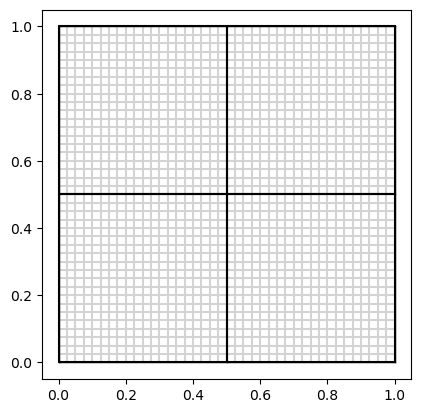

In [285]:
M.draw(knots=1)

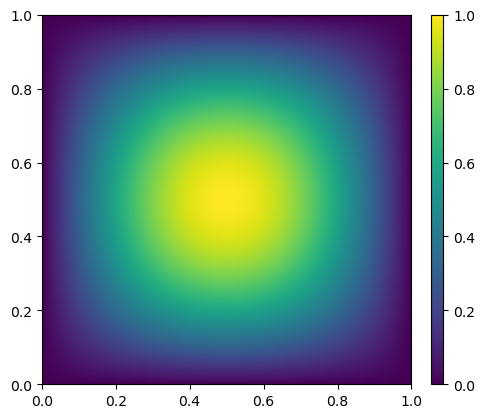

In [286]:
MP.plot(uh_IETI, cmap = 'viridis')

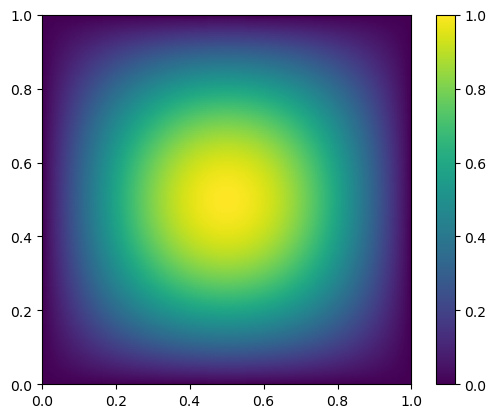

In [287]:
for geo in M.geos:
    vis.plot_field(u_exact, geo=geo, res=100, physical=True);
plt.axis('scaled');
plt.colorbar();

In [300]:
A = np.array([[3,1,6],[-6,0,-16],[0,8,-17]])

In [301]:
def LUdecomp(a):
    n = len(a)
    for k in range(0,n-1):
        for i in range(k+1,n):
            if a[i,k] != 0.0:
                lam = a [i,k]/a[k,k]
                a[i,k+1:n] = a[i,k+1:n] - lam*a[k,k+1:n]
                a[i,k] = lam
    return a

In [302]:
LUdecomp(A)

array([[ 3,  1,  6],
       [-2,  2, -4],
       [ 0,  4, -1]])